# Autoencoders in SciKeras

Autencoders are an approach to use nearual networks to distill data into it's most important features, thereby compressing the data. We will be following the [Keras tutorial](https://blog.keras.io/building-autoencoders-in-keras.html) on the topic, which goes much more in depth and breadth than we will here. You are highly encouraged to check out that tutorial if you want to learn about autoencoders in the general sense.

## Table of contents

* [1. Setup](#1.-Setup)
* [2. Data](#2.-Data)
* [3. Define Keras Model](#3.-Define-Keras-Model)
* [4. Training](#4.-Training)
* [5. Explore Results](#5.-Explore-Results)

## 1. Setup

In [1]:
try:
    import scikeras
except ImportError:
    !python -m pip install scikeras

Silence TensorFlow logging to keep output succinct.

In [2]:
import warnings
from tensorflow import get_logger
get_logger().setLevel('ERROR')
warnings.filterwarnings("ignore", message="Setting the random state for TF")

In [3]:
import numpy as np
from scikeras.wrappers import KerasClassifier, KerasRegressor
from tensorflow import keras

## 2. Data

We load the dataset from the Keras tutorial. The dataset consists of images of cats and dogs.

In [4]:
from tensorflow.keras.datasets import mnist
import numpy as np


(x_train, _), (x_test, _) = mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print(x_train.shape)
print(x_test.shape)

    8192/11490434 [..............................] - ETA: 0s

  368640/11490434 [..............................] - ETA: 1s

 5898240/11490434 [==============>...............] - ETA: 0s

11493376/11490434 [==============================] - 0s 0us/step


(60000, 784)
(10000, 784)


## 3. Define Keras Model

We will be defining a very simple autencoder. We define _three_ model building methods:

1. One to build a full end-to-end autoencoder.
2. One to create a model that includes only the encoder portion.
3. One that creates a model that includes only the decoder portion.

The only variable we give our model is the encoding dimensions, which will be a hyperparemter of our final transformer.

In [5]:
from tensorflow import keras


def get_fit_model(encoding_dim: int) -> keras.Model:
    """Get an autoencoder.

    This autoencoder compresses a 28x28 image (784 pixels) down to a feature of length
    `encoding_dim`, and tries to reconstruct the input image from that vector.
    """
    input_img = keras.Input(shape=(784,), name="input")
    encoded = keras.layers.Dense(encoding_dim, activation='relu', name="encoded")(input_img)
    decoded = keras.layers.Dense(784, activation='sigmoid', name="output")(encoded)
    autoencoder_model = keras.Model(input_img, decoded)
    return autoencoder_model

def get_tf_model(fit_model: keras.Model) -> keras.Model:
    """Get an encoder model.

    We do this by extracting the encoding layer from the fitted autoencoder model.
    """
    return keras.Model(fit_model.get_layer("input").input, fit_model.get_layer("encoded").output)

def get_inverse_tf_model(fit_model: keras.Model, encoding_dim: int) -> keras.Model:
    """Get an deencoder model.

    We do this by extracting the deencoding layer from the fitted autoencoder model
    and adding a new Keras input layer.
    """
    encoded_input = keras.Input(shape=(encoding_dim,))
    output = fit_model.get_layer("output")(encoded_input)
    return keras.Model(encoded_input, output)

Next we create a class that that will enable the `transform` and `fit_transform` methods, as well as integrating all three of our models into a single estimator.

In [6]:
from sklearn.base import TransformerMixin, clone
from scikeras.wrappers import BaseWrapper


class KerasTransformer(BaseWrapper, TransformerMixin):
    """A class that enables transform and fit_transform.
    """

    def __init__(self, *args, tf_est: BaseWrapper = None, inv_tf_est: BaseWrapper = None, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.tf_est = tf_est
        self.inv_tf_est = inv_tf_est


    def fit(self, X, sample_weight=None):
        super().fit(X=X, y=X, sample_weight=sample_weight)
        self.tf_est_ = clone(self.tf_est)
        self.inv_tf_est_ = clone(self.inv_tf_est)
        self.tf_est_.set_params(fit_model=self.model_)
        self.inv_tf_est_.set_params(fit_model=self.model_, encoding_dim=self.encoding_dim)
        X = self.feature_encoder_.transform(X)
        self.tf_est_.initialize(X=X)
        X_tf = self.tf_est_.predict(X=X)
        self.inv_tf_est_.initialize(X_tf)
        return self

    def transform(self, X):
        X = self.feature_encoder_.transform(X)
        X_tf = self.tf_est_.predict(X)
        return X_tf
    
    def inverse_transform(self, X_tf):
        X = self.inv_tf_est_.predict(X_tf)
        X = self.feature_encoder_.inverse_transform(X)
        return X

Next, we wrap the Keras Model with Scikeras. Note that for our encoder/decoder estimators, we do not need to provide a loss function since no training will be done. We do however need to have the `fit_model` and `encoding_dim` so that these will be settable by `BaseWrapper.set_params`.

In [7]:
tf_est = BaseWrapper(model=get_tf_model, fit_model=None, verbose=0)
inv_tf_est = BaseWrapper(model=get_inverse_tf_model, fit_model=None, encoding_dim=None, verbose=0)
autoencoder = KerasTransformer(model=get_fit_model, tf_est=tf_est, inv_tf_est=inv_tf_est, loss="binary_crossentropy", encoding_dim=32, epochs=5)

## 4. Training

To train the model, we pass the input images as both the features and the target. This will train the layers to compress the data as accurately as possible between the encoder and decoder. Note that we only pass the `X` parameter, since we defined the mapping `y=X` in `KerasTransformer.fit` above.

In [8]:
_ = autoencoder.fit(X=x_train)

Epoch 1/5


   1/1875 [..............................] - ETA: 12:12 - loss: 0.6934

  30/1875 [..............................] - ETA: 3s - loss: 0.5394   

  67/1875 [>.............................] - ETA: 2s - loss: 0.4485

 103/1875 [>.............................] - ETA: 2s - loss: 0.4063

 137/1875 [=>............................] - ETA: 2s - loss: 0.3812

 165/1875 [=>............................] - ETA: 2s - loss: 0.3657

 197/1875 [==>...........................] - ETA: 2s - loss: 0.3515

 230/1875 [==>...........................] - ETA: 2s - loss: 0.3394

 260/1875 [===>..........................] - ETA: 2s - loss: 0.3300

 292/1875 [===>..........................] - ETA: 2s - loss: 0.3213

 322/1875 [====>.........................] - ETA: 2s - loss: 0.3141

 354/1875 [====>.........................] - ETA: 2s - loss: 0.3072

 389/1875 [=====>........................] - ETA: 2s - loss: 0.3004

 421/1875 [=====>........................] - ETA: 2s - loss: 0.2948

 457/1875 [======>.......................] - ETA: 2s - loss: 0.2891

 487/1875 [======>.......................] - ETA: 2s - loss: 0.2847

 519/1875 [=======>......................] - ETA: 2s - loss: 0.2803

 552/1875 [=======>......................] - ETA: 2s - loss: 0.2761

 587/1875 [========>.....................] - ETA: 2s - loss: 0.2720

 621/1875 [========>.....................] - ETA: 1s - loss: 0.2682

 654/1875 [=========>....................] - ETA: 1s - loss: 0.2648

 689/1875 [==========>...................] - ETA: 1s - loss: 0.2614

 723/1875 [==========>...................] - ETA: 1s - loss: 0.2582

 756/1875 [===========>..................] - ETA: 1s - loss: 0.2554

 788/1875 [===========>..................] - ETA: 1s - loss: 0.2527

 824/1875 [============>.................] - ETA: 1s - loss: 0.2499

 854/1875 [============>.................] - ETA: 1s - loss: 0.2476

 886/1875 [=============>................] - ETA: 1s - loss: 0.2453

 920/1875 [=============>................] - ETA: 1s - loss: 0.2430

 954/1875 [==============>...............] - ETA: 1s - loss: 0.2407

 989/1875 [==============>...............] - ETA: 1s - loss: 0.2385

1028/1875 [===============>..............] - ETA: 1s - loss: 0.2362

1062/1875 [===============>..............] - ETA: 1s - loss: 0.2342

1095/1875 [================>.............] - ETA: 1s - loss: 0.2324

1130/1875 [=================>............] - ETA: 1s - loss: 0.2305

1159/1875 [=================>............] - ETA: 1s - loss: 0.2290

1191/1875 [==================>...........] - ETA: 1s - loss: 0.2274

1228/1875 [==================>...........] - ETA: 0s - loss: 0.2256

1259/1875 [===================>..........] - ETA: 0s - loss: 0.2242

1297/1875 [===================>..........] - ETA: 0s - loss: 0.2225

1330/1875 [====================>.........] - ETA: 0s - loss: 0.2210

1368/1875 [====================>.........] - ETA: 0s - loss: 0.2194

1403/1875 [=====================>........] - ETA: 0s - loss: 0.2180

1439/1875 [======================>.......] - ETA: 0s - loss: 0.2166

1470/1875 [======================>.......] - ETA: 0s - loss: 0.2154

1502/1875 [=======================>......] - ETA: 0s - loss: 0.2142

1534/1875 [=======================>......] - ETA: 0s - loss: 0.2130

1564/1875 [========================>.....] - ETA: 0s - loss: 0.2119

1598/1875 [========================>.....] - ETA: 0s - loss: 0.2108

1631/1875 [=========================>....] - ETA: 0s - loss: 0.2097

1667/1875 [=========================>....] - ETA: 0s - loss: 0.2085

1705/1875 [==========================>...] - ETA: 0s - loss: 0.2073

1736/1875 [==========================>...] - ETA: 0s - loss: 0.2063

1775/1875 [===========================>..] - ETA: 0s - loss: 0.2051

1806/1875 [===========================>..] - ETA: 0s - loss: 0.2042

1837/1875 [============================>.] - ETA: 0s - loss: 0.2033

1872/1875 [============================>.] - ETA: 0s - loss: 0.2023

1875/1875 [==============================] - 3s 2ms/step - loss: 0.2022


Epoch 2/5
   1/1875 [..............................] - ETA: 4s - loss: 0.1141

  36/1875 [..............................] - ETA: 2s - loss: 0.1127

  67/1875 [>.............................] - ETA: 2s - loss: 0.1119

 100/1875 [>.............................] - ETA: 2s - loss: 0.1115

 133/1875 [=>............................] - ETA: 2s - loss: 0.1112

 169/1875 [=>............................] - ETA: 2s - loss: 0.1109

 203/1875 [==>...........................] - ETA: 2s - loss: 0.1106

 235/1875 [==>...........................] - ETA: 2s - loss: 0.1104

 274/1875 [===>..........................] - ETA: 2s - loss: 0.1101

 309/1875 [===>..........................] - ETA: 2s - loss: 0.1100

 344/1875 [====>.........................] - ETA: 2s - loss: 0.1098

 376/1875 [=====>........................] - ETA: 2s - loss: 0.1096

 411/1875 [=====>........................] - ETA: 2s - loss: 0.1095

 442/1875 [======>.......................] - ETA: 2s - loss: 0.1094

 474/1875 [======>.......................] - ETA: 2s - loss: 0.1093

 504/1875 [=======>......................] - ETA: 2s - loss: 0.1092

 536/1875 [=======>......................] - ETA: 2s - loss: 0.1091

 570/1875 [========>.....................] - ETA: 1s - loss: 0.1090

 601/1875 [========>.....................] - ETA: 1s - loss: 0.1088

 636/1875 [=========>....................] - ETA: 1s - loss: 0.1087

 668/1875 [=========>....................] - ETA: 1s - loss: 0.1086

 700/1875 [==========>...................] - ETA: 1s - loss: 0.1086

 732/1875 [==========>...................] - ETA: 1s - loss: 0.1085

 764/1875 [===========>..................] - ETA: 1s - loss: 0.1084

 796/1875 [===========>..................] - ETA: 1s - loss: 0.1083

 821/1875 [============>.................] - ETA: 1s - loss: 0.1082

 854/1875 [============>.................] - ETA: 1s - loss: 0.1082

 887/1875 [=============>................] - ETA: 1s - loss: 0.1081

 912/1875 [=============>................] - ETA: 1s - loss: 0.1080

 936/1875 [=============>................] - ETA: 1s - loss: 0.1080

 968/1875 [==============>...............] - ETA: 1s - loss: 0.1079

 994/1875 [==============>...............] - ETA: 1s - loss: 0.1078

1024/1875 [===============>..............] - ETA: 1s - loss: 0.1078

1052/1875 [===============>..............] - ETA: 1s - loss: 0.1077

1079/1875 [================>.............] - ETA: 1s - loss: 0.1076

1109/1875 [================>.............] - ETA: 1s - loss: 0.1076

1140/1875 [=================>............] - ETA: 1s - loss: 0.1075

1168/1875 [=================>............] - ETA: 1s - loss: 0.1074

1193/1875 [==================>...........] - ETA: 1s - loss: 0.1074

1222/1875 [==================>...........] - ETA: 1s - loss: 0.1073

1250/1875 [===================>..........] - ETA: 1s - loss: 0.1073

1279/1875 [===================>..........] - ETA: 0s - loss: 0.1072

1312/1875 [===================>..........] - ETA: 0s - loss: 0.1071

1337/1875 [====================>.........] - ETA: 0s - loss: 0.1071

1366/1875 [====================>.........] - ETA: 0s - loss: 0.1070

1397/1875 [=====================>........] - ETA: 0s - loss: 0.1070

1427/1875 [=====================>........] - ETA: 0s - loss: 0.1069

1457/1875 [======================>.......] - ETA: 0s - loss: 0.1069

1489/1875 [======================>.......] - ETA: 0s - loss: 0.1068

1519/1875 [=======================>......] - ETA: 0s - loss: 0.1067

1551/1875 [=======================>......] - ETA: 0s - loss: 0.1067

1580/1875 [========================>.....] - ETA: 0s - loss: 0.1066

1609/1875 [========================>.....] - ETA: 0s - loss: 0.1066

1635/1875 [=========================>....] - ETA: 0s - loss: 0.1065

1665/1875 [=========================>....] - ETA: 0s - loss: 0.1065

1695/1875 [==========================>...] - ETA: 0s - loss: 0.1064

1726/1875 [==========================>...] - ETA: 0s - loss: 0.1064

1756/1875 [===========================>..] - ETA: 0s - loss: 0.1063

1785/1875 [===========================>..] - ETA: 0s - loss: 0.1063

1812/1875 [===========================>..] - ETA: 0s - loss: 0.1062

1835/1875 [============================>.] - ETA: 0s - loss: 0.1062

1865/1875 [============================>.] - ETA: 0s - loss: 0.1062

1875/1875 [==============================] - 3s 2ms/step - loss: 0.1061


Epoch 3/5
   1/1875 [..............................] - ETA: 2s - loss: 0.0881

  33/1875 [..............................] - ETA: 2s - loss: 0.0980

  60/1875 [..............................] - ETA: 3s - loss: 0.0980

  94/1875 [>.............................] - ETA: 2s - loss: 0.0981

 127/1875 [=>............................] - ETA: 2s - loss: 0.0982

 154/1875 [=>............................] - ETA: 2s - loss: 0.0983

 190/1875 [==>...........................] - ETA: 2s - loss: 0.0983

 227/1875 [==>...........................] - ETA: 2s - loss: 0.0984

 263/1875 [===>..........................] - ETA: 2s - loss: 0.0984

 299/1875 [===>..........................] - ETA: 2s - loss: 0.0984

 333/1875 [====>.........................] - ETA: 2s - loss: 0.0984

 368/1875 [====>.........................] - ETA: 2s - loss: 0.0984

 404/1875 [=====>........................] - ETA: 2s - loss: 0.0984

 441/1875 [======>.......................] - ETA: 2s - loss: 0.0984

 477/1875 [======>.......................] - ETA: 2s - loss: 0.0984

 514/1875 [=======>......................] - ETA: 2s - loss: 0.0984

 548/1875 [=======>......................] - ETA: 1s - loss: 0.0984

 576/1875 [========>.....................] - ETA: 1s - loss: 0.0985

 601/1875 [========>.....................] - ETA: 1s - loss: 0.0985

 632/1875 [=========>....................] - ETA: 1s - loss: 0.0985

 660/1875 [=========>....................] - ETA: 1s - loss: 0.0985

 689/1875 [==========>...................] - ETA: 1s - loss: 0.0985

 716/1875 [==========>...................] - ETA: 1s - loss: 0.0985

 744/1875 [==========>...................] - ETA: 1s - loss: 0.0985

 770/1875 [===========>..................] - ETA: 1s - loss: 0.0984

 799/1875 [===========>..................] - ETA: 1s - loss: 0.0984

 834/1875 [============>.................] - ETA: 1s - loss: 0.0984

 861/1875 [============>.................] - ETA: 1s - loss: 0.0984

 889/1875 [=============>................] - ETA: 1s - loss: 0.0984

 918/1875 [=============>................] - ETA: 1s - loss: 0.0984

 946/1875 [==============>...............] - ETA: 1s - loss: 0.0984

 976/1875 [==============>...............] - ETA: 1s - loss: 0.0984

1009/1875 [===============>..............] - ETA: 1s - loss: 0.0984

1037/1875 [===============>..............] - ETA: 1s - loss: 0.0984

1066/1875 [================>.............] - ETA: 1s - loss: 0.0984

1092/1875 [================>.............] - ETA: 1s - loss: 0.0984

1125/1875 [=================>............] - ETA: 1s - loss: 0.0984

1161/1875 [=================>............] - ETA: 1s - loss: 0.0984

1192/1875 [==================>...........] - ETA: 1s - loss: 0.0984

1227/1875 [==================>...........] - ETA: 1s - loss: 0.0984

1263/1875 [===================>..........] - ETA: 0s - loss: 0.0984

1298/1875 [===================>..........] - ETA: 0s - loss: 0.0983

1334/1875 [====================>.........] - ETA: 0s - loss: 0.0983

1361/1875 [====================>.........] - ETA: 0s - loss: 0.0983

1391/1875 [=====================>........] - ETA: 0s - loss: 0.0983

1426/1875 [=====================>........] - ETA: 0s - loss: 0.0983

1461/1875 [======================>.......] - ETA: 0s - loss: 0.0983

1488/1875 [======================>.......] - ETA: 0s - loss: 0.0983

1523/1875 [=======================>......] - ETA: 0s - loss: 0.0983

1556/1875 [=======================>......] - ETA: 0s - loss: 0.0983

1592/1875 [========================>.....] - ETA: 0s - loss: 0.0982

1618/1875 [========================>.....] - ETA: 0s - loss: 0.0982

1650/1875 [=========================>....] - ETA: 0s - loss: 0.0982

1674/1875 [=========================>....] - ETA: 0s - loss: 0.0982

1700/1875 [==========================>...] - ETA: 0s - loss: 0.0982

1725/1875 [==========================>...] - ETA: 0s - loss: 0.0982

1753/1875 [===========================>..] - ETA: 0s - loss: 0.0982

1778/1875 [===========================>..] - ETA: 0s - loss: 0.0982

1812/1875 [===========================>..] - ETA: 0s - loss: 0.0982

1847/1875 [============================>.] - ETA: 0s - loss: 0.0981

1875/1875 [==============================] - 3s 2ms/step - loss: 0.0981


Epoch 4/5
   1/1875 [..............................] - ETA: 2s - loss: 0.0999

  33/1875 [..............................] - ETA: 2s - loss: 0.0972

  66/1875 [>.............................] - ETA: 2s - loss: 0.0969

  96/1875 [>.............................] - ETA: 2s - loss: 0.0967

 130/1875 [=>............................] - ETA: 2s - loss: 0.0967

 166/1875 [=>............................] - ETA: 2s - loss: 0.0966

 203/1875 [==>...........................] - ETA: 2s - loss: 0.0966

 239/1875 [==>...........................] - ETA: 2s - loss: 0.0966

 271/1875 [===>..........................] - ETA: 2s - loss: 0.0965

 297/1875 [===>..........................] - ETA: 2s - loss: 0.0965

 333/1875 [====>.........................] - ETA: 2s - loss: 0.0965

 369/1875 [====>.........................] - ETA: 2s - loss: 0.0965

 403/1875 [=====>........................] - ETA: 2s - loss: 0.0965

 439/1875 [======>.......................] - ETA: 2s - loss: 0.0965

 475/1875 [======>.......................] - ETA: 2s - loss: 0.0965

 509/1875 [=======>......................] - ETA: 2s - loss: 0.0965

 543/1875 [=======>......................] - ETA: 1s - loss: 0.0965

 578/1875 [========>.....................] - ETA: 1s - loss: 0.0964

 612/1875 [========>.....................] - ETA: 1s - loss: 0.0964

 637/1875 [=========>....................] - ETA: 1s - loss: 0.0964

 671/1875 [=========>....................] - ETA: 1s - loss: 0.0964

 700/1875 [==========>...................] - ETA: 1s - loss: 0.0964

 730/1875 [==========>...................] - ETA: 1s - loss: 0.0964

 763/1875 [===========>..................] - ETA: 1s - loss: 0.0964

 795/1875 [===========>..................] - ETA: 1s - loss: 0.0964

 823/1875 [============>.................] - ETA: 1s - loss: 0.0964

 857/1875 [============>.................] - ETA: 1s - loss: 0.0964

 892/1875 [=============>................] - ETA: 1s - loss: 0.0963

 926/1875 [=============>................] - ETA: 1s - loss: 0.0963

 960/1875 [==============>...............] - ETA: 1s - loss: 0.0963

 995/1875 [==============>...............] - ETA: 1s - loss: 0.0963

1020/1875 [===============>..............] - ETA: 1s - loss: 0.0963

1052/1875 [===============>..............] - ETA: 1s - loss: 0.0963

1087/1875 [================>.............] - ETA: 1s - loss: 0.0963

1122/1875 [================>.............] - ETA: 1s - loss: 0.0963

1158/1875 [=================>............] - ETA: 1s - loss: 0.0963

1194/1875 [==================>...........] - ETA: 1s - loss: 0.0963

1228/1875 [==================>...........] - ETA: 0s - loss: 0.0963

1263/1875 [===================>..........] - ETA: 0s - loss: 0.0963

1298/1875 [===================>..........] - ETA: 0s - loss: 0.0963

1323/1875 [====================>.........] - ETA: 0s - loss: 0.0963

1350/1875 [====================>.........] - ETA: 0s - loss: 0.0963

1379/1875 [=====================>........] - ETA: 0s - loss: 0.0963

1411/1875 [=====================>........] - ETA: 0s - loss: 0.0963

1443/1875 [======================>.......] - ETA: 0s - loss: 0.0963

1477/1875 [======================>.......] - ETA: 0s - loss: 0.0963

1506/1875 [=======================>......] - ETA: 0s - loss: 0.0963

1541/1875 [=======================>......] - ETA: 0s - loss: 0.0963

1576/1875 [========================>.....] - ETA: 0s - loss: 0.0962

1612/1875 [========================>.....] - ETA: 0s - loss: 0.0962

1647/1875 [=========================>....] - ETA: 0s - loss: 0.0962

1671/1875 [=========================>....] - ETA: 0s - loss: 0.0962

1694/1875 [==========================>...] - ETA: 0s - loss: 0.0962

1721/1875 [==========================>...] - ETA: 0s - loss: 0.0962

1747/1875 [==========================>...] - ETA: 0s - loss: 0.0962

1779/1875 [===========================>..] - ETA: 0s - loss: 0.0962

1807/1875 [===========================>..] - ETA: 0s - loss: 0.0962

1832/1875 [============================>.] - ETA: 0s - loss: 0.0962

1858/1875 [============================>.] - ETA: 0s - loss: 0.0962

1875/1875 [==============================] - 3s 2ms/step - loss: 0.0962


Epoch 5/5
   1/1875 [..............................] - ETA: 3s - loss: 0.0904

  26/1875 [..............................] - ETA: 3s - loss: 0.0952

  55/1875 [..............................] - ETA: 3s - loss: 0.0955

  82/1875 [>.............................] - ETA: 3s - loss: 0.0956

 110/1875 [>.............................] - ETA: 3s - loss: 0.0956

 137/1875 [=>............................] - ETA: 3s - loss: 0.0955

 159/1875 [=>............................] - ETA: 3s - loss: 0.0955

 185/1875 [=>............................] - ETA: 3s - loss: 0.0955

 210/1875 [==>...........................] - ETA: 3s - loss: 0.0955

 238/1875 [==>...........................] - ETA: 3s - loss: 0.0955

 267/1875 [===>..........................] - ETA: 3s - loss: 0.0955

 295/1875 [===>..........................] - ETA: 3s - loss: 0.0955

 316/1875 [====>.........................] - ETA: 3s - loss: 0.0955

 345/1875 [====>.........................] - ETA: 3s - loss: 0.0955

 376/1875 [=====>........................] - ETA: 2s - loss: 0.0955

 402/1875 [=====>........................] - ETA: 2s - loss: 0.0955

 430/1875 [=====>........................] - ETA: 2s - loss: 0.0955

 455/1875 [======>.......................] - ETA: 2s - loss: 0.0955

 484/1875 [======>.......................] - ETA: 2s - loss: 0.0955

 507/1875 [=======>......................] - ETA: 2s - loss: 0.0955

 536/1875 [=======>......................] - ETA: 2s - loss: 0.0955

 562/1875 [=======>......................] - ETA: 2s - loss: 0.0955

 590/1875 [========>.....................] - ETA: 2s - loss: 0.0955

 616/1875 [========>.....................] - ETA: 2s - loss: 0.0956

 651/1875 [=========>....................] - ETA: 2s - loss: 0.0956

 679/1875 [=========>....................] - ETA: 2s - loss: 0.0955

 702/1875 [==========>...................] - ETA: 2s - loss: 0.0955

 726/1875 [==========>...................] - ETA: 2s - loss: 0.0955

 756/1875 [===========>..................] - ETA: 2s - loss: 0.0955

 784/1875 [===========>..................] - ETA: 2s - loss: 0.0955

 812/1875 [===========>..................] - ETA: 2s - loss: 0.0955

 840/1875 [============>.................] - ETA: 1s - loss: 0.0956

 869/1875 [============>.................] - ETA: 1s - loss: 0.0956

 895/1875 [=============>................] - ETA: 1s - loss: 0.0956

 920/1875 [=============>................] - ETA: 1s - loss: 0.0955

 945/1875 [==============>...............] - ETA: 1s - loss: 0.0955

 971/1875 [==============>...............] - ETA: 1s - loss: 0.0955

1000/1875 [===============>..............] - ETA: 1s - loss: 0.0955

1026/1875 [===============>..............] - ETA: 1s - loss: 0.0955

1051/1875 [===============>..............] - ETA: 1s - loss: 0.0955

1083/1875 [================>.............] - ETA: 1s - loss: 0.0955

1116/1875 [================>.............] - ETA: 1s - loss: 0.0955

1150/1875 [=================>............] - ETA: 1s - loss: 0.0955

1184/1875 [=================>............] - ETA: 1s - loss: 0.0955

1208/1875 [==================>...........] - ETA: 1s - loss: 0.0955

1234/1875 [==================>...........] - ETA: 1s - loss: 0.0955

1262/1875 [===================>..........] - ETA: 1s - loss: 0.0955

1291/1875 [===================>..........] - ETA: 1s - loss: 0.0955

1322/1875 [====================>.........] - ETA: 1s - loss: 0.0955

1355/1875 [====================>.........] - ETA: 0s - loss: 0.0955

1385/1875 [=====================>........] - ETA: 0s - loss: 0.0955

1417/1875 [=====================>........] - ETA: 0s - loss: 0.0955

1452/1875 [======================>.......] - ETA: 0s - loss: 0.0955

1484/1875 [======================>.......] - ETA: 0s - loss: 0.0955

1507/1875 [=======================>......] - ETA: 0s - loss: 0.0955

1538/1875 [=======================>......] - ETA: 0s - loss: 0.0955

1572/1875 [========================>.....] - ETA: 0s - loss: 0.0955

1598/1875 [========================>.....] - ETA: 0s - loss: 0.0955

1628/1875 [=========================>....] - ETA: 0s - loss: 0.0955

1654/1875 [=========================>....] - ETA: 0s - loss: 0.0955

1688/1875 [==========================>...] - ETA: 0s - loss: 0.0955

1723/1875 [==========================>...] - ETA: 0s - loss: 0.0955

1757/1875 [===========================>..] - ETA: 0s - loss: 0.0955

1791/1875 [===========================>..] - ETA: 0s - loss: 0.0955

1826/1875 [============================>.] - ETA: 0s - loss: 0.0955

1860/1875 [============================>.] - ETA: 0s - loss: 0.0955

1875/1875 [==============================] - 3s 2ms/step - loss: 0.0955


Next, we round trip the test dataset and explore the performance of the autoencoder.

In [9]:
roundtrip_imgs = autoencoder.inverse_transform(autoencoder.transform(x_test))

## 5. Explore Results

Let's compare our inputs to lossy decoded outputs:

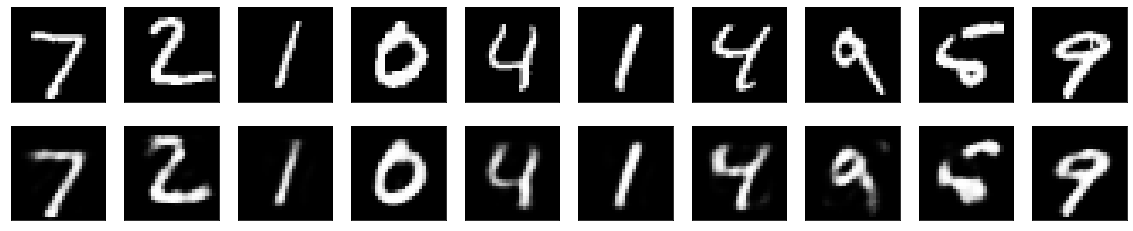

In [10]:
import matplotlib.pyplot as plt


n = 10  # How many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(roundtrip_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

What about the compression? Let's check the sizes of the arrays.

In [11]:
encoded_imgs = autoencoder.transform(x_test)
print(f"x_test.shape[1]: {x_test.shape[1]}")
print(f"encoded_imgs.shape[1]: {encoded_imgs.shape[1]}")
cr = round((encoded_imgs.nbytes/x_test.nbytes), 2)
print(f"Compression ratio: 1/{1/cr:.0f}")

x_test.shape[1]: 784
encoded_imgs.shape[1]: 32
Compression ratio: 1/25
